TODO: going to implement a basic MNIST like classifer to classify the digits of
persian license plate

- generate fake dataset or find it
- train a classifier (yolo or torch?)
- get test score (acc, f1, conf_matrix, ...)
- save it and give it to the license plate recognition script/notebook



In [ ]:
!pip install roboflow

In [4]:
from roboflow import Roboflow
from google.colab import userdata

api_key = userdata.get('RF_TOKEN')
rf = Roboflow(api_key=api_key)
project = rf.workspace("object-detection-yolov5").project("plate_ocr_ir")
version = project.version(2)
dataset = version.download("folder")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to plate_ocr_ir-2 in folder:: 100%|██████████| 9658/9658 [00:01<00:00, 8830.92it/s]


In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transformations for the images
transform = transforms.Compose([
    transforms.Grayscale(),        # Ensure images are grayscale
    transforms.Resize((28, 28)),   # Resize to 28x28
    transforms.ToTensor(),         # Convert to tensor
])

# Load the train dataset using ImageFolder
dataset_path = dataset.location + "/train"
train_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load the valid dataset using ImageFolder
dataset_path = dataset.location + "/valid"
valid_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)

# Print class names
print(f"Classes: {train_dataset.classes}")


Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'ch', 'd', 'ein', 'f', 'g', 'ghaf', 'ghein', 'h2', 'hj', 'j', 'k', 'kh', 'l', 'm', 'n', 'p', 'r', 's', 'sad', 'sh', 't', 'ta', 'th', 'v', 'y', 'z', 'za', 'zad', 'zal', 'zh']


In [22]:
len(train_dataset.classes)

42

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class FCModel(nn.Module):
    def __init__(self, num_classes):
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
num_classes = len(train_dataset.classes)
model = FCModel(num_classes)


In [19]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):

    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:

        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_val_loss = val_loss / len(valid_loader)
    val_accuracy = 100 * correct / total

    # Epoch finished
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%\n")

print("Training complete!")


Epoch [1/100]
Train Loss: 3.3632 | Val Loss: 2.3897 | Val Accuracy: 29.92%

Epoch [2/100]
Train Loss: 2.3074 | Val Loss: 1.6883 | Val Accuracy: 48.74%

Epoch [3/100]
Train Loss: 1.9363 | Val Loss: 1.4659 | Val Accuracy: 55.56%

Epoch [4/100]
Train Loss: 1.6994 | Val Loss: 1.3651 | Val Accuracy: 56.82%

Epoch [5/100]
Train Loss: 1.5295 | Val Loss: 1.2659 | Val Accuracy: 57.70%

Epoch [6/100]
Train Loss: 1.3818 | Val Loss: 1.0789 | Val Accuracy: 65.53%

Epoch [7/100]
Train Loss: 1.2602 | Val Loss: 0.9801 | Val Accuracy: 67.42%

Epoch [8/100]
Train Loss: 1.1474 | Val Loss: 0.9590 | Val Accuracy: 68.94%

Epoch [9/100]
Train Loss: 1.0528 | Val Loss: 0.8866 | Val Accuracy: 69.57%

Epoch [10/100]
Train Loss: 0.9885 | Val Loss: 0.8925 | Val Accuracy: 72.10%

Epoch [11/100]
Train Loss: 0.9045 | Val Loss: 0.7786 | Val Accuracy: 75.88%

Epoch [12/100]
Train Loss: 0.8331 | Val Loss: 0.7218 | Val Accuracy: 76.89%

Epoch [13/100]
Train Loss: 0.7778 | Val Loss: 0.7389 | Val Accuracy: 77.27%

Epoch [1

KeyboardInterrupt: 

Classification Report:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       0.92      1.00      0.96        12
           2       0.91      1.00      0.95        10
           3       0.78      0.88      0.82         8
           4       1.00      0.75      0.86        12
           5       0.83      0.71      0.77         7
           6       0.89      1.00      0.94         8
           7       0.92      0.92      0.92        12
           8       0.91      1.00      0.95        10
           9       1.00      1.00      1.00         5
           a       0.00      0.00      0.00         1
           b       1.00      1.00      1.00        14
          ch       0.73      0.73      0.73        15
           d       0.78      1.00      0.88         7
         ein       0.89      0.89      0.89         9
           f       1.00      1.00      1.00         7
           g       0.88      1.00      0.93         7
    

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


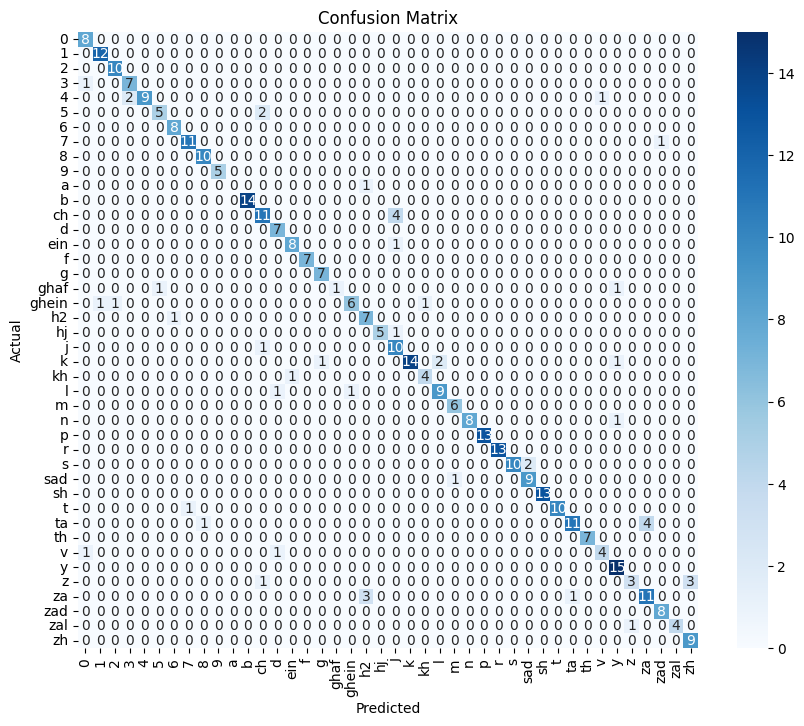

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load test dataset using ImageFolder
test_dataset_path = dataset.location + "/test"  # Update with your test dataset path
test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Evaluate the model and store predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)
classes = test_dataset.classes

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# Compute and print F1-score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Weighted F1-Score: {f1:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [30]:
digits  = np.load('digits.npy')
model.eval()
pred_idx = model(torch.tensor(digits[1]).float().unsqueeze(0)).argmax()
classes[pred_idx]

'zad'

In [21]:
# download the model
torch.save(model.state_dict(), "persian_digit_classifier.pt")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import cv2
import numpy as np


# Define the MNIST-like Fully Connected Model
class FCModel(nn.Module):
    def __init__(self, num_classes):
        super(FCModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# ImageClassifier class encapsulating model loading, preprocessing, and prediction
class ImageClassifier:
    def __init__(self, weights_path, class_names):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.class_names = class_names
        self.model = self._load_model(weights_path)
        self.model.to(self.device)
        self.model.eval()
        self.transform = self._get_transform()

    def _load_model(self, weights_path):
        """Load the trained model with weights."""
        num_classes = len(self.class_names)
        model = FCModel(num_classes)
        model.load_state_dict(torch.load(weights_path, map_location=self.device))
        print("Model loaded successfully.")
        return model

    def _get_transform(self):
        """Define the preprocessing transformations."""
        return transforms.Compose([
            transforms.Grayscale(),           # Convert to grayscale
            transforms.Resize((28, 28)),      # Resize to 28x28
            transforms.ToTensor(),            # Convert to tensor
        ])

    def preprocess_image(self, image):
        """Preprocess the input OpenCV image."""
        # Convert BGR to RGB (OpenCV loads images in BGR by default)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Apply transformations
        image_tensor = self.transform(image_rgb).unsqueeze(0)  # Add batch dimension
        return image_tensor.to(self.device)

    def predict(self, image):
        """Predict the class of the given image."""
        image_tensor = self.preprocess_image(image)
        with torch.no_grad():
            outputs = self.model(image_tensor)
            _, predicted = torch.max(outputs, 1)
            predicted_class = self.class_names[predicted.item()]
        return predicted_class


# Example usage
if __name__ == "__main__":
    weights_path = 'persian_digit_classifier.pt'
    class_names = ['class1', 'class2', 'class3']

    classifier = ImageClassifier(weights_path, class_names)

    # Read an image using OpenCV
    image_path = 'path/to/your/image.jpg'  # Update this with the path to your test image
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error: Unable to load image at {image_path}")
    else:
        # Predict the class
        predicted_class = classifier.predict(image)
        print(f"Predicted Class: {predicted_class}")
